In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
path_to_ml_20m = "data/spotify/"

In [95]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import itertools
import time
import umap
import paths

def plot_pareto2(most_stable, all_stable_paths, save=False):
    # stabs = [p[1] for p in most_stable.values()]
    # lens = list(most_stable.keys())
        
    unoptimal_paths = np.array([(n, s[1]) for n, ps in all_stable_paths.items() for s in ps])
    optimal_paths = np.array([(n,ps[1]) for n, ps in most_stable.items()])

    ax = plt.figure(figsize=(20,10)).gca()  
    ax.xaxis.set_major_locator(MaxNLocator(integer=True)) 
    plt.subplot(111)
    
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 

    cmap = plt.get_cmap('tab10')
    plt.scatter(unoptimal_paths[:,0], unoptimal_paths[:,1], color=cmap(1), label='Nonoptimal paths')
    plt.scatter(optimal_paths[:,0], optimal_paths[:,1], label='Optimal paths')
    plt.plot(optimal_paths[:,0], optimal_paths[:,1], label='Pareto frontier')


    plt.xlabel("Length of path")
    plt.ylabel("Instability of path")

    plt.legend()
    ticks = range(int(min(optimal_paths[:,0])), int(max(optimal_paths[:,0])) + 1)
    plt.xticks(ticks)
    if save!=False:
        plt.savefig(save,)


#from cechmate import Cover
class BaseFiltration:
    def __init__(self, max_dim=3):
        
        self.max_dim = max_dim
        
        
class Cover(BaseFiltration):
    def __init__(self, max_dim):
        super().__init__(max_dim)
        self.covers = None
        self.simplices = None
        self.dists = []  
    
    def build(self, covers):

        # Give each cover element a name.
        if not isinstance(covers, dict):
            covers = dict(enumerate(covers))
            
        simplices = [([k], 0.0) for k in covers.keys()]
        
        # TODO: be more intelligent about which combos we check

        #Changed self.max_dim+1 to self.max_dim+2. Correct?
        for k in range(2, self.max_dim + 2):
            for potentials in itertools.combinations(covers.keys(), k):
                potential_sets = [covers[p] for p in potentials]

                d = self.jaccard(potential_sets)
                self.dists.append(d)

                # TODO: Do we want to include all of these simplices as well?
                if d < 1:
                    simplices.append((potentials, d))
        
        self.covers = covers
        self.simplices = simplices
        self.d = d
        
        return simplices

    def jaccard(self, covers):
        covers_as_sets = list(map(set, covers))
        intersection = set.intersection(*covers_as_sets)
        union = set.union(*covers_as_sets)

        return 1 - len(intersection) / len(union)


__all__ = ['Cover']

%matplotlib inline

pd.options.display.max_rows = 8

## Choose 5 particular genres

In [4]:
"""
Possible genres:

Action
Adventure
Animation
Children's
Comedy
Crime
Documentary
Drama
Fantasy
Film-Noir
Horror
Musical
Mystery
Romance
Sci-Fi
Thriller
War
Western
(no genres listed)
"""

#MAJOR_CATS = ['Action', 'Drama', 'Comedy', 'Romance', 'Horror']
#MAJOR_CATS = ['Adventure', "Children", "Musical", "Sci-Fi", "Western"]

# BAD_CATS = ['Film-Noir', '(no genre listed)']

"\nPossible genres:\n\nAction\nAdventure\nAnimation\nChildren's\nComedy\nCrime\nDocumentary\nDrama\nFantasy\nFilm-Noir\nHorror\nMusical\nMystery\nRomance\nSci-Fi\nThriller\nWar\nWestern\n(no genres listed)\n"

## Load ratings

In [5]:
ratings = pd.read_csv(os.path.join(path_to_ml_20m, "pls_songs.csv"), delimiter=",")\
            .drop(columns=['order', 'track_uri'])


## Load movies information

In [6]:
print('something')

something


In [7]:
movie_info = pd.read_csv(os.path.join(path_to_ml_20m, "tracks.csv"), delimiter=",")
movie_info

,id,track_uri,track_name,artist_name
0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott
1,1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears
2,2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé
3,3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake
...,...,...,...,...
2262288,2262288,spotify:track:1Uo65qTxnCg1N1X00lgcjr,Shalom - Pax217 Album Version,Pax217
2262289,2262289,spotify:track:5uEE5tii66I0cC7kZ7IMxE,Free To Be - Pax217 Album Version,Pax217
2262290,2262290,spotify:track:6A1RfnrMdxb24OYllzzTUX,Skwid - Pax217 Album Version,Pax217
2262291,2262291,spotify:track:5DvykFHB6utG6Hozpt5eNK,Running Thin,Straw Theory


In [8]:
movie_info = movie_info.dropna()

In [9]:
movie_info.loc[movie_info.track_name.str.contains("Shape of You")]

,id,track_uri,track_name,artist_name
1064,1064,spotify:track:7qiZfU4dY1lWllzX7mPBI3,Shape of You,Ed Sheeran
1662,1662,spotify:track:5H7CwzYZ60e7w69tX4ivQN,Shape of You - Galantis Remix,Ed Sheeran
29917,29917,spotify:track:1KqvRRQd3lfM0pAlkGPrgD,Shape of You (Major Lazer Remix) [feat. Nyla &...,Ed Sheeran
67721,67721,spotify:track:5nCtCCB5i1OfbADvynNw0i,Shape of You (Latin Remix) [feat. Zion & Lennox],Ed Sheeran
...,...,...,...,...
2092207,2092207,spotify:track:0v2WItKxInx9szDEBVwDri,Shape of You (Ultimate Mashup): One Dance / Th...,against the crowds
2152319,2152319,spotify:track:3qKmYSGjmDal87MSccmlge,Shape of You,Alexa Goddard
2210857,2210857,spotify:track:2QN0g3afGilgifTG9CHgUx,Shape of You,Like Ghosts
2244755,2244755,spotify:track:0EcwTOpCLiXl5Ks3VeeovZ,Shape of You - Reggae Version,Groove Da Praia


In [10]:
movie_info.loc[movie_info.track_name.str.contains("Royale")]

,id,track_uri,track_name,artist_name
26938,26938,spotify:track:1FzbUxPXtF7q9M5Q7q49Gk,Work - Bad Royale Remix,Rihanna
87103,87103,spotify:track:4HHIVS7mHAXqXVebo3k5Um,"You Know My Name - From ""Casino Royale"" Soundt...",Chris Cornell
93889,93889,spotify:track:3DsuPfINKQKK6JnM8USOJN,Calm Down - Bad Royale Remix,Skip Marley
98144,98144,spotify:track:2djMHt15r92lGDg1bBMzJN,Cattle Royale,Lyk
...,...,...,...,...
2185763,2185763,spotify:track:4Ej6iGlyo8wdZZtIvWJPJt,Depression Royale,De-Phazz
2194707,2194707,spotify:track:3D3yYanxubc43CA6kVYNcd,Dynamo Royale,Dynamo Productions
2225907,2225907,spotify:track:2mTmPKk4QvLsQHHzluLoYZ,Helicopter - Bad Royale Remix,TWRK
2240474,2240474,spotify:track:4FAUqBdLBCC0R0W4O7WOtF,Casino Royale - You Know My Name,The City of Prague Philharmonic Orchestra


In [11]:
toxic = 1
toxicity = 2516
thriller = 304

carryonmywayward = 74
bohemian = 75

helpbeatles = 475
shapeofu= 1064

""""

transformers = 53996
notebook = 8533
princess = 1197

darko = 4878
chainsaw = 6880

mulan = 1907 
rouge = 4308
""" 

'"\n\ntransformers = 53996\nnotebook = 8533\nprincess = 1197\n\ndarko = 4878\nchainsaw = 6880\n\nmulan = 1907 \nrouge = 4308\n'

- Toxic -> Toxicity
- Toxicity -> Bolero...

- Transformers $\to$ The Notebook 
- The Princess Bride $\to$ Donnie Darko
- Texas Chainsaw Massacre $\to$ Mulan
- Mulan $\to$ Moulin Rouge

## Filter movies to only particular subset

- filter out lots of movies that won't matter 
- ones that only have a few ratings




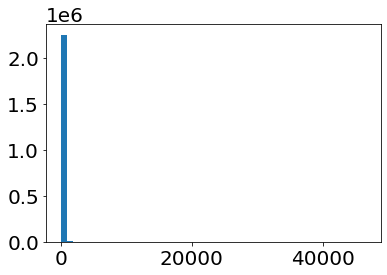

In [187]:
%%time
movies = ratings.groupby('id')

movies_map = {name: list(group.pid) for name, group in movies}
movies_ratings_n = [len(m) for m in movies_map.values()]


In [20]:
len(movies)

2262292

In [24]:
movies_ratings_n[1]

13205

In [13]:
len(movies_ratings_n)

2262292

In [19]:
print(len(movies_ratings_n))
print(len([n for n in movies_ratings_n if n >= 2]))

2262292
1188873


In [158]:
%%time
slim_movies_map = {name: ls for name, ls in movies_map.items() if len(ls) >= 3}

toxic = 1
toxicity = 2516
thriller = 304

carryonmywayward = 74
bohemian = 75

helpbeatles = 475
shapeofu = 1064


good_movies = [toxic, toxicity,thriller, carryonmywayward,bohemian, helpbeatles,shapeofu]
np.random.seed(1)

rate = 800 / len(movies_map)
slimer_movies_map = {name: ls for name, ls in movies_map.items() 
                     if np.random.random() <= rate or name in good_movies}

Wall time: 1.39 s


In [159]:
len(movies_map)

2262292

In [160]:
print(rate)

0.00035362367015398543


In [161]:
len(slimer_movies_map)

834

In [157]:
1000. / len(movies_map)

0.0004420295876924818

In [47]:
%%time
for m in good_movies:
    assert m in slimer_movies_map.keys()

Wall time: 0 ns


In [48]:
"""
%%time
filt = lambda x: '|'.join(set(x.split('|')).intersection(MAJOR_CATS))
isin = lambda x: len(set(x.split('|')).intersection(MAJOR_CATS)) > 0
def get_year(x):
    try:
        return int(x.strip()[-6:][1:-1])
    except:
        return 1


movie_info['year'] = movie_info['title'].apply(get_year)

# movie_info = movie_info[movie_info['year'] > 2000]
# movie_info['major_cat'] = movie_info['genres'].apply(isin)
# movie_info['genres'] = movie_info['genr es'].apply(filt)
# movie_info = movie_info[movie_info['major_cat'] == True]
movie_info
"""

"\n%%time\nfilt = lambda x: '|'.join(set(x.split('|')).intersection(MAJOR_CATS))\nisin = lambda x: len(set(x.split('|')).intersection(MAJOR_CATS)) > 0\ndef get_year(x):\n    try:\n        return int(x.strip()[-6:][1:-1])\n    except:\n        return 1\n\n\nmovie_info['year'] = movie_info['title'].apply(get_year)\n\n# movie_info = movie_info[movie_info['year'] > 2000]\n# movie_info['major_cat'] = movie_info['genres'].apply(isin)\n# movie_info['genres'] = movie_info['genr es'].apply(filt)\n# movie_info = movie_info[movie_info['major_cat'] == True]\nmovie_info\n"

## Sample only middle percentile of movie and user

based on number of users rating each movie, and number of movies each user rates.

In [49]:
ratings

,pid,id
0,0,0
1,0,1
2,0,2
3,0,3
...,...,...
66346424,999999,288294
66346425,999999,141054
66346426,999999,141039
66346427,999999,72395


In [50]:
movie_info

,id,track_uri,track_name,artist_name
0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott
1,1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears
2,2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé
3,3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake
...,...,...,...,...
2262288,2262288,spotify:track:1Uo65qTxnCg1N1X00lgcjr,Shalom - Pax217 Album Version,Pax217
2262289,2262289,spotify:track:5uEE5tii66I0cC7kZ7IMxE,Free To Be - Pax217 Album Version,Pax217
2262290,2262290,spotify:track:6A1RfnrMdxb24OYllzzTUX,Skwid - Pax217 Album Version,Pax217
2262291,2262291,spotify:track:5DvykFHB6utG6Hozpt5eNK,Running Thin,Straw Theory


In [421]:
%%time
def sample_middle_movies(ratings, lower=0.5, upper=0.95):
    """ Sample just middle percentiles of movies
    
    """
    movies = ratings.groupby('id')
    movies_map = {name: list(group.pid) for name, group in movies}

    movies_ratings_n = [len(m) for m in movies_map.values()]
    lower_bound, upper_bound = pd.Series(movies_ratings_n).quantile([lower, upper]).values
    print(f"Remove movies with # ratings <= {lower_bound} and # ratings >= {upper_bound}")

    movies_map = {name: mlist for name, mlist in movies_map.items() if lower_bound <= len(mlist) <= upper_bound}
    print(f"Was {len(movies_ratings_n)}, now {len(movies_map)} movies in the range.")
    
    return movies_map

def sample_middle_users(lower=0.6, upper=0.95):
    """ sample middle percentiles of users
    
    """
    users = ratings.groupby('pid')
    users_map = {name: list(group.id) for name, group in users}

    users_ratings_n = [len(m) for m in users_map.values()]
    lower_bound, upper_bound = pd.Series(users_ratings_n).quantile([lower, upper]).values
    print(f"Remove movies with # ratings <= {lower_bound} and # ratings >= {upper_bound}")

    users_map = {name: ulist for name, ulist in users_map.items() if lower_bound <= len(ulist) <= upper_bound}
    print(f"Was {len(users_ratings_n)}, now {len(users_map)} users in the range.")
    
    return users_map

def particular_movies_sample(ratings, n=15000):
    
    # limit to only middle percentile users 
    users_map = sample_middle_users()
    ok_users = list(users_map.keys())
    sub_ratings = ratings[(ratings['id'].isin(ok_users))]
    
    # Filter only particular movies
    print(f"--{len(sub_ratings)} movie reviews after filtering users")
    sub_ratings = sub_ratings[sub_ratings['id'].isin(movie_info.id)]
    print(f"--{len(sub_ratings)} movie reviews after filtering good movies")
    
    # Get movies with middle percentiles          
    movies_map = sample_middle_movies(sub_ratings)
    print(len(movies_map))
    print("Sample movies")
    rate = n / len(movies_map)
    print(rate)
    # then randomly sample the movies
    np.random.seed(1)
    movies_map = {m:l for m,l in movies_map.items() if np.random.random() <= rate}
    
    print(f"Resulting dataset has {len(movies_map)} movies")
    return movies_map

Wall time: 5.98 ms


In [422]:
%%time
movies_map = particular_movies_sample(ratings) #comentada de antes

Remove movies with # ratings <= 62.0 and # ratings >= 184.0
Was 1000000, now 355415 users in the range.
--23111660 movie reviews after filtering users
--23111660 movie reviews after filtering good movies
Remove movies with # ratings <= 5.0 and # ratings >= 155.0
Was 355415, now 172278 movies in the range.
172278
Sample movies
0.08706857520983527
Resulting dataset has 15183 movies
Wall time: 7min 27s


## Build cover and filtration from selected movies

In [423]:
len(movies_map)

15183

In [424]:
%%time
def thresh_filt(filtration, thresh):
    filtration = [f for f in filtration if f[1] < thresh]
    return filtration
    
def build_graph(filtration, thresh=None):
    """ Build a networkx graph out of the 1-skeleton in the filtration
    """
    if thresh:
        filtration = thresh_filt(filtration, thresh)
    vertices = [s[0][0] for s in filtration if len(s[0]) == 1]
    edges = [s[0] for s in filtration if len(s[0]) == 2]
    edge_attrs = {s[0]: s[1] for s in filtration if len(s[0]) == 2}
    edge_weights = list(edge_attrs.values())
    
    g = nx.Graph()
    g.add_nodes_from(vertices)
    g.add_edges_from(edges)
    nx.set_edge_attributes(g, edge_attrs, 'dist')

    return g

Wall time: 0 ns


In [425]:
%%time
start = time.time()
c = Cover(max_dim=1)
filtration = c.build(movies_map)

vertices = [s for s in filtration if len(s[0]) == 1]
edges = [s for s in filtration if len(s[0]) == 2]

# Make sure we have vertices and edges and no triangles
assert len(filtration) == len(vertices) + len(edges)
assert len(edges) > 0
g = build_graph(filtration)
end = time.time()
print(end-start)

452.1643741130829
Wall time: 7min 32s


In [429]:
g.number_of_nodes()

15183

In [430]:
g.number_of_edges()

175176

In [431]:
c.

SyntaxError: invalid syntax (1195783164.py, line 1)

In [432]:
sorted(c.dists)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.07692307692307687,
 0.08333333333333337,
 0.11111111111111116,
 0.11111111111111116,
 0.11111111111111116,
 0.11111111111111116,
 0.11111111111111116,
 0.11111111111111116,
 0.11111111111111116,
 0.11111111111111116,
 0.11111111111111116,
 0.11111111111111116,
 0.11111111111111116,
 0.125,
 0.125,
 0.125,
 0.1428571428571429,
 0.15384615384615385,
 0.15384615384615385,
 0.15384615384615385,
 0.15384615384615385,
 0.15384615384615385,
 0.16666666666666663,
 0.16666666666666663,
 0.16666666666666663,
 0.16666666666666663,
 0.16666666666666663,
 0.17647058823529416,
 0.18181818181818177,
 0.19565217391304346,
 0.19999999999999996,
 0.19999999999999996,
 0.19999999999999996,
 0.19999999999999996,
 0.19999999999999996,
 0.19999999999999996,
 0.19999999999999996,
 0.19999999999999996,
 0.19999999999999996,
 0.21052631578947367,
 0.2142857142857143,
 0.2142857142857143,
 0.2222

In [433]:
#Once a graph is generated, it can be saved and loaded through nx.write_gpickle and nx.read_gpickle. 

'''
import networkx as nx
nx.write_gpickle(g,'7000_sample_graph')

SyntaxError: EOF while scanning triple-quoted string literal (2349727418.py, line 5)

In [ ]:
#g2=nx.read_gpickle('7000_sample_graph')

## Mulan $\to$ Mulan Rouge

In [434]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import MaxNLocator
import networkx as nx
from matplotlib.collections import LineCollection

# source, terminal = paths.utils.random_st(g, 1)
def movie_names_in_path(ms):
    movies_in_path = ms[0]
    pms = [movie_info.loc[movie_info.movieId == m].title.values[0] for m in movies_in_path]
    return pms

#Set save=True when calling to save output as files
def paths_demo(g, source, terminal,save=False):
    most_stable, all_stable_paths = paths.most_stable_paths(g, source, terminal)
    #paths.draw.plot_pareto(most_stable, all_stable_paths)
    plot_pareto2(most_stable, all_stable_paths, save=False)
    print(str(source))
    with open('Output/'+str(source)+'_'+str(terminal)+str(s)+'_samples.txt', 'a+') as f:
        for k, p in most_stable.items():
            print(p)
            print(k, ":\n\t", "\n\t".join(movie_names_in_path(p)))
            if save==True:
                f.write(str(p))
                f.write(str(k)+":\n\t"+"\n\t")
                for movie in movie_names_in_path(p):
                    f.write(str(movie)+":\n\t"+"\n\t")
        

In [435]:
list(movies_map.keys())[10]

1489

In [436]:
%%time
movie_info.loc[movie_info.id == list(movies_map.keys())[10]]

Wall time: 21 ms


,id,track_uri,track_name,artist_name
1489,1489,spotify:track:6r51t6szECkyxfN4rX6yqs,Always N Forever,The Orwells


In [437]:
%%time
movie_info.loc[movie_info.id == list(movies_map.keys())[20]]

Wall time: 6.98 ms


,id,track_uri,track_name,artist_name
2209,2209,spotify:track:3bhzFxDOmbpYHUAnf6HHV6,Desiree,The Ranch


- Transformers $\to$ The Notebook 
- The Princess Bride $\to$ Donnie Darko
- Texas Chainsaw Massacre $\to$ Mulan
- Mulan $\to$ Moulin Rouge

- transformers = 53996
- notebook = 8533
- princess = 1197
- darko = 4878
- chainsaw = 6880
- mulan = 1907
- rouge = 4308

1489


C:\Users\Alpaca\AppData\Local\Temp\ipykernel_52692\823338577.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(111)


FileNotFoundError: [Errno 2] No such file or directory: 'Output/1489_22093_samples.txt'

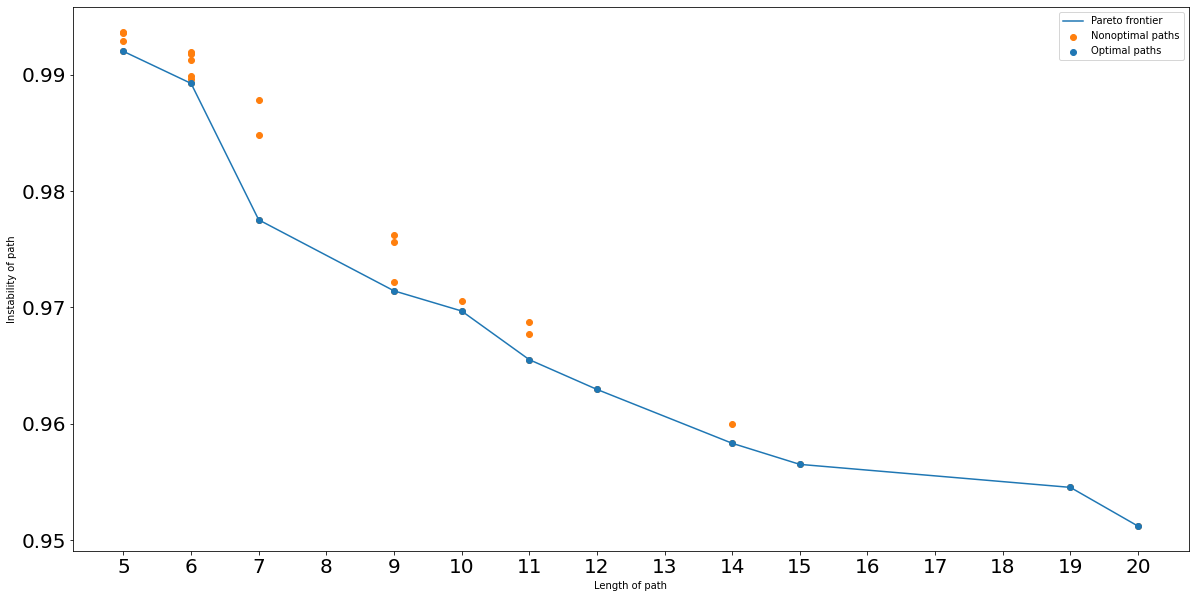

In [438]:
%%time
paths_demo(g, list(movies_map.keys())[10], list(movies_map.keys())[20])

11736


C:\Users\Alpaca\AppData\Local\Temp\ipykernel_52692\823338577.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(111)


FileNotFoundError: [Errno 2] No such file or directory: 'Output/11736_219683_samples.txt'

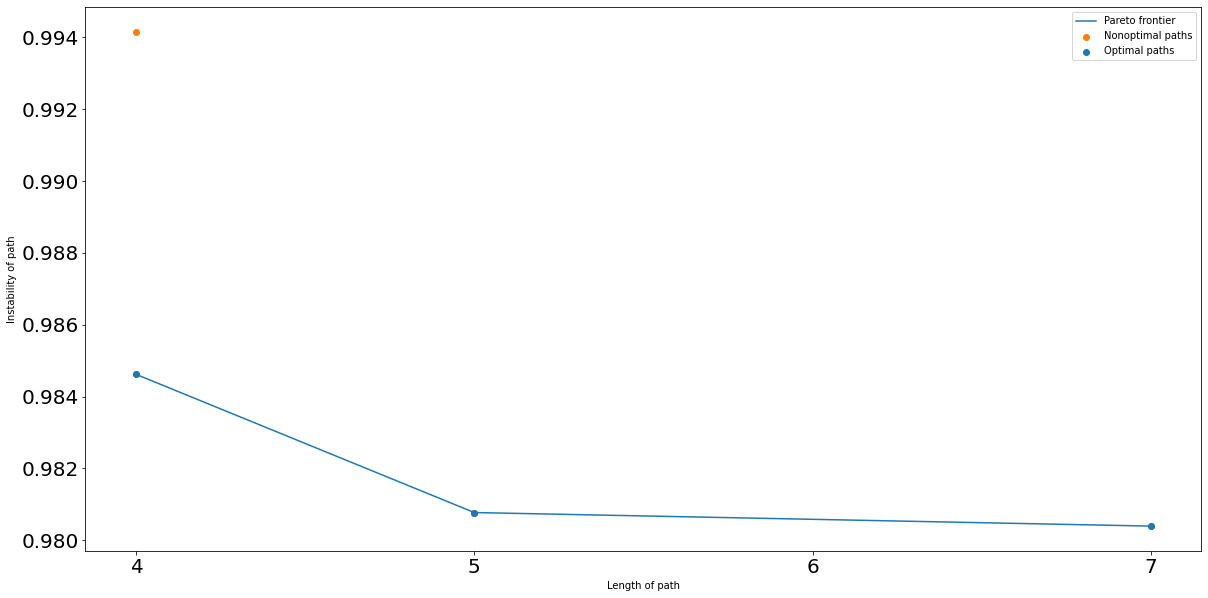

In [439]:
%%time
paths_demo(g,list(movies_map.keys())[100], list(movies_map.keys())[200])

In [440]:
paths_demo(g, transformers, notebook)

NameError: name 'transformers' is not defined

In [441]:
paths_demo(g, princess, darko)

NameError: name 'princess' is not defined

## Compute pareto frontier between $s$ and $t$

In [442]:
%%time
most_stable, all_stable_paths = paths.most_stable_paths(g, list(movies_map.keys())[1100], list(movies_map.keys())[25])
#paths.draw.plot_pareto(most_stable, all_stable_paths)
# plt.savefig("movies_pareto_1.png")

#17 secs consulta sample 30k

Wall time: 2 s


In [443]:
all_stable_paths

{3: [([74883, 112572, 3050], 0.9928057553956835)],
 5: [([74883, 33726, 159851, 295781, 3050], 0.9921259842519685),
  ([74883, 580259, 65376, 90423, 3050], 0.991869918699187),
  ([74883, 426490, 112597, 112572, 3050], 0.9873417721518988)],
 6: [([74883, 580259, 124085, 262384, 112572, 3050], 0.9850746268656716),
  ([74883, 734608, 123270, 162133, 345035, 3050], 0.9836065573770492),
  ([74883, 734608, 804490, 197079, 197118, 3050], 0.9743589743589743)],
 9: [([74883, 734608, 667945, 170770, 796516, 1846, 197079, 197118, 3050],
   0.9736842105263158),
  ([74883, 734608, 667945, 170770, 485158, 620711, 197079, 197118, 3050],
   0.9722222222222222)]}

In [447]:
%%time
def movie_names_in_path(ms):
    movies_in_path = ms[0]
    pms = [movie_info.loc[movie_info.id == m].track_name.values[0] for m in movies_in_path]
    return pms

print("\n".join(movie_names_in_path(most_stable[3])))
print()
print("\n".join(movie_names_in_path(most_stable[6])))
print()
print("\n".join(movie_names_in_path(most_stable[9])))

Howl's Moving Castle Theme (From 'Howl's Moving Castle')
Preliminary Art Form
19 In 99

Howl's Moving Castle Theme (From 'Howl's Moving Castle')
The Dragon Boy (From 'Spirited Away')
Death of Titanic
Still
Weird World
19 In 99

Howl's Moving Castle Theme (From 'Howl's Moving Castle')
The Dragon Boy (From 'Spirited Away')
Myth
What Took You So Long
The Soft Side Of Love
Please Protect My Heart
Still
Weird World
19 In 99
Wall time: 61.8 ms


In [448]:
most_stable

{3: ([74883, 112572, 3050], 0.9928057553956835),
 5: ([74883, 426490, 112597, 112572, 3050], 0.9873417721518988),
 6: ([74883, 734608, 804490, 197079, 197118, 3050], 0.9743589743589743),
 9: ([74883, 734608, 667945, 170770, 485158, 620711, 197079, 197118, 3050],
  0.9722222222222222)}

In [446]:
%%time
from matplotlib.collections import LineCollection

pos = nx.kamada_kawai_layout(g)
print('we have pos')
instability = np.array([v for _, v in most_stable.values()])

points = [np.array([pos[u] for u in path])
          for path, _ in most_stable.values()]

n = len(points)
print(n)
s = 3

plt.figure(figsize=(s*n, s))
colors = np.array(['lightgray', 'black'])

for i, path in enumerate(points):
    background = LineCollection(points, linewidth=6, color='lightgray')
    lines = LineCollection([path], color='black')
    
    ax = plt.subplot(1, n, i + 1)
    ax.add_collection(background)
    ax.add_collection(lines)
    ax.scatter(*path[[0, -1]].T, s=100, c='k', zorder=2)
    ax.autoscale_view()

    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title(f'{len(points[i])} / {instability[i]:.3f}')
    
#plt.savefig('small_multiples_movies.png')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Alpaca\AppData\Roaming\Python\Python39\site-packages\IPython\core\magics\execution.py", line 1335, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 3, in <module>
  File "C:\Users\Alpaca\miniconda3\lib\site-packages\networkx\drawing\layout.py", line 689, in kamada_kawai_layout
    dist = dict(nx.shortest_path_length(G, weight=weight))
  File "C:\Users\Alpaca\miniconda3\lib\site-packages\networkx\algorithms\shortest_paths\weighted.py", line 1063, in all_pairs_dijkstra_path_length
    yield (n, length(G, n, cutoff=cutoff, weight=weight))
  File "C:\Users\Alpaca\miniconda3\lib\site-packages\networkx\algorithms\shortest_paths\weighted.py", line 373, in single_source_dijkstra_path_length
    return multi_source_dijkstra_path_length(G, {source}, cutoff=cutoff, weight=weight)
  File "C:\Users\Alpaca\miniconda3\lib\site-packages\networkx\algorithms\shortest_paths\weighted.py", line 628, in multi_source_dijkstra_path_length
 

TypeError: object of type 'NoneType' has no len()

## Plot the pareto frontier on the graph using kamada kawaii and UMAP

In [321]:
gcc = g.subgraph(max(nx.connected_components(g), key=len))
paths.draw.draw_stable_paths(gcc, most_stable, chainsaw, mulan)

AttributeError: module 'paths' has no attribute 'draw'

In [449]:
def UMAP_positions(g, filtration):

    def distances_fast(g, vertices, vertex_map):
        """This shouldn't be used, it was a first pass, fast but not very accurate."""
        dists = np.zeros((len(vertices), len(vertices)))
        from itertools import combinations
        for s,e in combinations(vertices, 2):

            if (s,e) in g.edges:
                dists[vertex_map[e], vertex_map[s]] = g.edges[s,e]['dist']
                dists[vertex_map[s], vertex_map[e]] = g.edges[s,e]['dist']
            elif (e,s) in g.edges:
                print("edge backwards is in")
            else:
                dists[vertex_map[e], vertex_map[s]] = 10
                dists[vertex_map[s], vertex_map[e]] = 10

        return dists

    vertices = [v[0][0] for v in filtration if len(v[0]) == 1]
    vertex_map = {v:k for k,v in enumerate(vertices)}
    dists = distances_fast(g, vertices, vertex_map)
    print("Found distances")

    embedding = umap.UMAP(n_neighbors=10, metric='precomputed').fit_transform(dists)
    print("umap embedding computed")
    keys = np.array(list(vertex_map.keys()))
    pos = {k: embedding[v] for k,v in vertex_map.items()}
    
    return embedding, pos, keys

In [451]:
%%time
embedding, pos, keys = UMAP_positions(g, filtration)
#paths.draw.draw_stable_paths(g, most_stable, list(movies_map.keys())[10], list(movies_map.keys())[20], pos=pos)

Found distances


C:\Users\Alpaca\miniconda3\lib\site-packages\umap\umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


umap embedding computed
Wall time: 4min 34s


## Cluster the UMAP embedding and see how well it clustered

In [455]:
%%time
from sklearn import cluster

def genre_hist(genres_list, v, ax):
    from collections import Counter
    each = [g for x in genres_list for g in x.split('|')]
    c = dict(Counter(each))
    
    cs = []
    for m in MAJOR_CATS:
        if m in c.keys():
            cs.append(c[m])
        else:
            cs.append(0)
        
    cmap = plt.get_cmap("tab10")
    
    ax.bar(range(len(MAJOR_CATS)), cs, align='center', color=cmap(int(v)), alpha=0.5)
    ax.set_xticks(range(len(MAJOR_CATS)))
    ax.set_xticklabels( list(MAJOR_CATS), rotation=45 )

Wall time: 963 µs


Wall time: 2.49 s


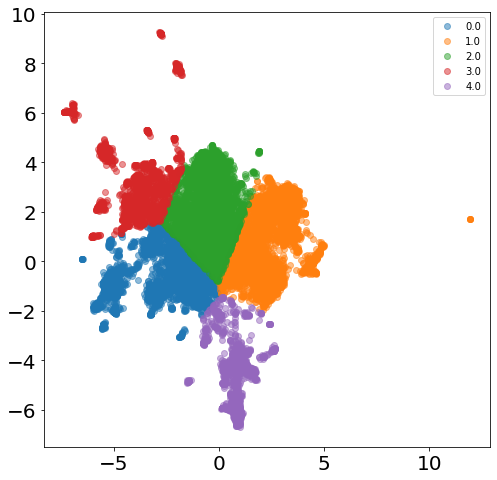

In [457]:
%%time
clusterer = cluster.KMeans(5)
clusterer.fit(embedding)

ds = np.hstack([keys.reshape(-1,1), embedding, clusterer.labels_.reshape(-1, 1)])
df = pd.DataFrame(ds, columns=['key', 'x', 'y', 'cluster'])
clusters = df.groupby('cluster')
plt.figure(figsize=(8,8))

for c, da in clusters:
    alpha = 0.5
    plt.scatter(*da[['x', 'y']].values.T, label=c, alpha=alpha)
plt.legend()

In [121]:
MAJOR_CATS

NameError: name 'MAJOR_CATS' is not defined

KeyError: 'movieId'

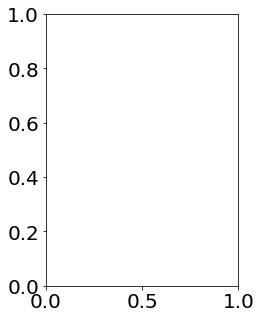

In [454]:
plt.figure(figsize=(20,5))

v = 0.0
ax = plt.subplot(151)
cluster_vals = clusters.get_group(v)['key'].values
genres_in = movie_info.loc[movie_info['movieId'].isin(cluster_vals)].genres.values
genre_hist(genres_in, v, ax)

v = 1.0
ax = plt.subplot(152)
cluster_vals = clusters.get_group(v)['key'].values
genres_in = movie_info.loc[movie_info['movieId'].isin(cluster_vals)].genres.values
genre_hist(genres_in, v, ax)

v = 2.0
ax = plt.subplot(153)
cluster_vals = clusters.get_group(v)['key'].values
genres_in = movie_info.loc[movie_info['movieId'].isin(cluster_vals)].genres.values
genre_hist(genres_in, v, ax)

v = 3.0
ax = plt.subplot(154)
cluster_vals = clusters.get_group(v)['key'].values
genres_in = movie_info.loc[movie_info['movieId'].isin(cluster_vals)].genres.values
genre_hist(genres_in, v, ax)

v = 4.0
ax = plt.subplot(155)
cluster_vals = clusters.get_group(v)['key'].values
genres_in = movie_info.loc[movie_info['movieId'].isin(cluster_vals)].genres.values
genre_hist(genres_in, v, ax)

## Look at some steps in the filtration 

NetworkXError: Node 112 has no position.

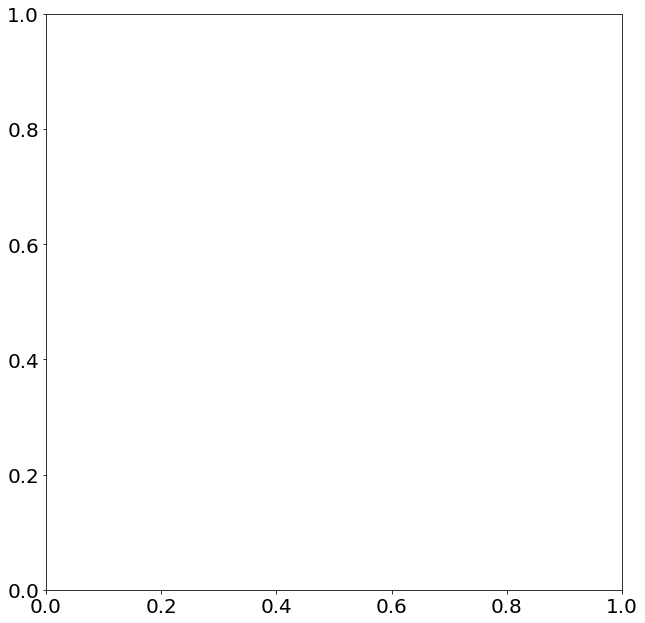

In [372]:
def filter_plot(filtration, thresh, pos=None):
    pos = pos or nx.kamada_kawai_layout()
    filtration = [f for f in filtration if f[1] < thresh]
    g = build_graph(filtration, thresh)
    
    plt.figure(figsize=(8,8))
    edges = g.edges()
    weights = [g[u][v]['dist'] for u,v in edges]
    nx.draw(g, pos=pos, node_size=20, alpha=0.2)
    plt.show()

filter_plot(filtration, 0.90, pos)
filter_plot(filtration, 0.95, pos)
filter_plot(filtration, 0.98, pos)

In [375]:
g.size()

175176